<a href="https://colab.research.google.com/github/mdavistr-cmu/Davis-Troller_DSPN_S25/blob/main/ExerciseSubmissions/Davis-Troller_Exercise17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/CoAxLab/Data-Explorations/blob/main/book/exercises/regularized-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 17: Regularized regression

This homework assignment is designed to give you an intuition as an interesting property of regularization in the context of ultra-high dimensional statistical problems.

You won't need to load in any data for this homework.

---
## 1. Simulating & visualizing data (2 points)

We are going to be looking at what happens in the context where $p>n$. In order to have total control over our data, we will use simulations for this homework. First, we will need to load the `glmnet`, `tidyverse`, and `ggplot2` libraries for this assignment.


In [10]:
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [11]:

library(glmnet)
library(tidyverse)
library(ggplot2)

We are going to generate a data set with complex structure and try to recover it using polynomial models. For simplicity sake, use the following code to produce a response variable, $y$ that has complex structure.

*Hint: Look up what a cosine function looks like if you need a reminder.*

In [12]:
# Generate data
set.seed(121)
sigma_noise = .5
x=seq(-9,9,by=.18)
n=length(x)
y = 0.1*x + cos(x) + cos(x/20)+rnorm(n,sd=sigma_noise)

(a) Break the data into a training set (n=50) and test set (n=51) using the `sample` function to randomly select subsets of x and y.  Make a separate data frame for the training and test data.

(**Note**: *Do not* just take the first 50 observations to be the training set and last 51 observations to be the test set.)

In [13]:
train_indices <- sample(1:n, size = 50, replace = FALSE)
test_indices <- setdiff(1:n, train_indices)

train_data <- data.frame(x = x[train_indices], y = y[train_indices])
test_data <- data.frame(x = x[test_indices], y = y[test_indices])

nrow(train_data)  # Should be 50
nrow(test_data)   # Should be 51

head(train_data)
head(test_data)

[1] 50

[1] 51

,x,y
,<dbl>,<dbl>
1,-7.56,-0.08663415
2,5.58,2.40786448
3,1.80,1.00645142
4,-0.54,2.01487369
5,-1.44,0.10934315
6,-4.86,1.08539063


,x,y
,<dbl>,<dbl>
1,-8.46,-0.5442746
2,-8.10,0.6732243
3,-7.20,1.5256458
4,-7.02,0.5469083
5,-6.84,0.9066007
6,-6.66,0.9259283


(b) Plot the training data ($x$ \& $y$). Describe the relationship that you see in the training data.

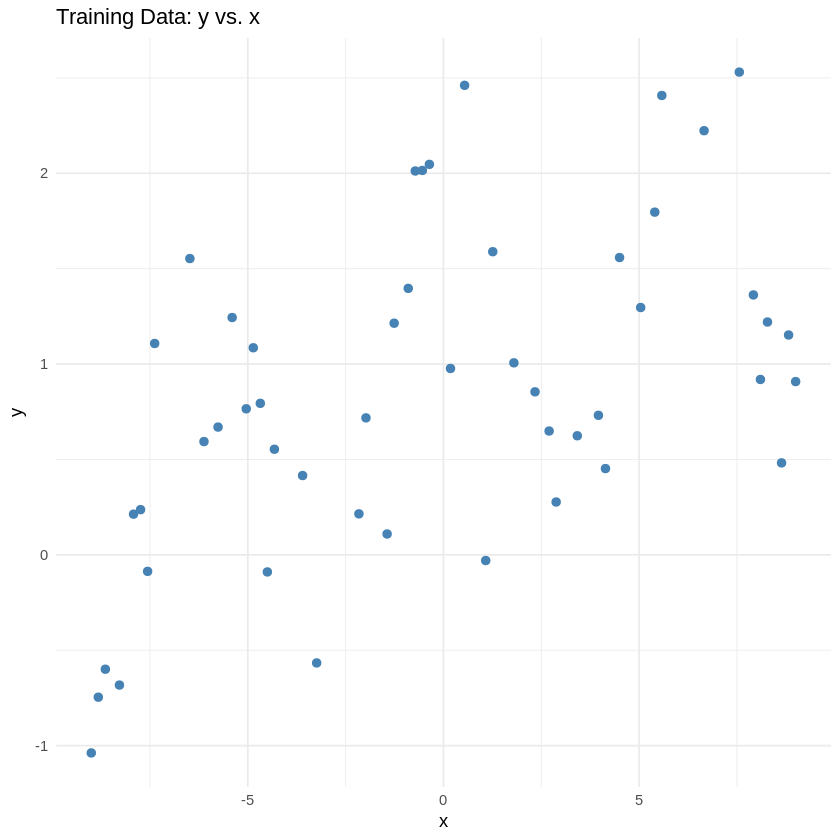

In [14]:
ggplot(train_data, aes(x = x, y = y)) +
  geom_point(color = "steelblue", size = 2) +
  ggtitle("Training Data: y vs. x") +
  xlab("x") +
  ylab("y") +
  theme_minimal()




How would you describe the relationship between $x$ and $y$ based on this plot?

> The relationship between $x$ and $y$ is non-linear and oscillatory.
>

---
## 2. Bias-variance tradeoff: polynomial regression (4 points)

Recall that in polynomial regression we increase model complexity by expanding $x$ out to the power $k$ (which we call degree).


$$Y = \hat{\beta}_0 + \sum_{j=1}^K \hat{\beta}_jX^j $$  

$$ = poly(x,k)$$

(a) Fit a 2nd degree polynomial regression model to the training data. Plot the results.


*Hint: Use the* `help` *function to see how to use the* `stat_smooth()` *and* `poly()` *functions.*

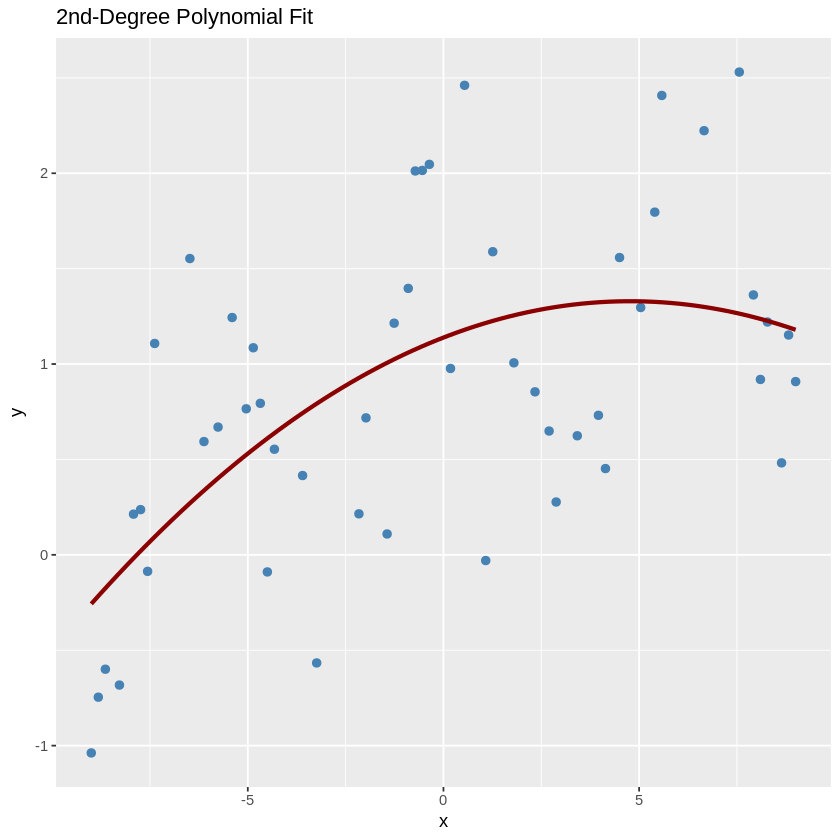

In [15]:
model_deg2 <- lm(y ~ poly(x, 2), data = train_data)

# Plot training data with fitted polynomial curve
ggplot(train_data, aes(x = x, y = y)) +
  geom_point(color = "steelblue", size = 2) +
  stat_smooth(method = "lm", formula = y ~ poly(x, 2),
              se = FALSE, color = "darkred", size = 1.2) +
  ggtitle("2nd-Degree Polynomial Fit") +
  xlab("x") +
  ylab("y")




How well does this 2nd degree polynomial model qualitatively fit the data? Could it do better?

> It captures the general trend but does not quantify the oscillations of the data sufficiently. Therefore, it is too simple of a model.
>

(b) Fit a 12th degree polynomial to the data. Does this do qualitatively better or worse than the 2nd degree model?

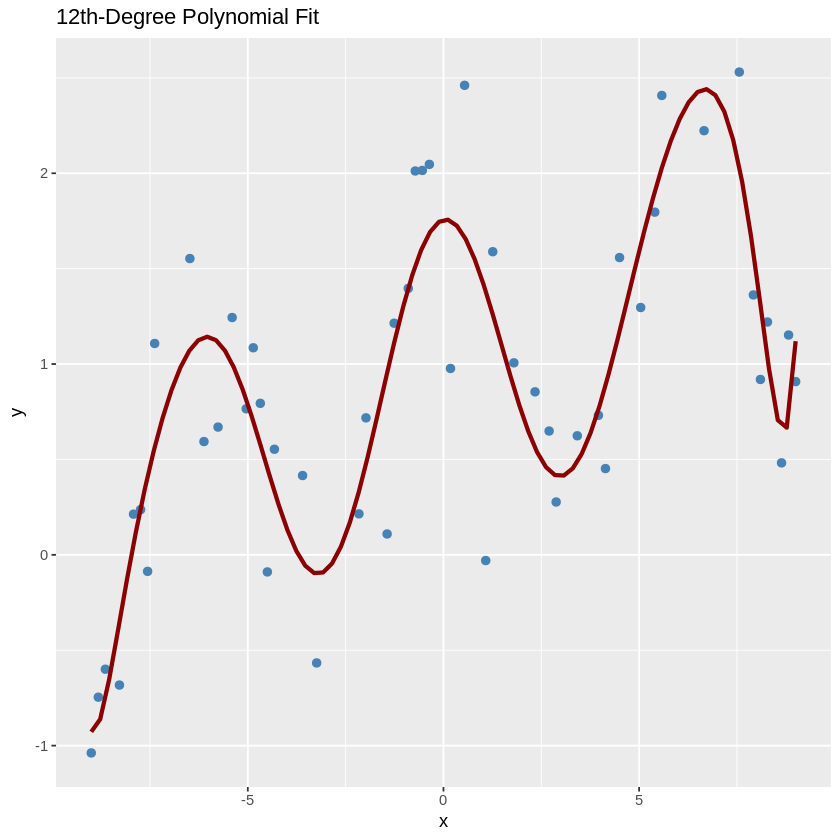

In [16]:
model_deg12 <- lm(y ~ poly(x, 12), data = train_data)

# Plot training data with fitted polynomial curve
ggplot(train_data, aes(x = x, y = y)) +
  geom_point(color = "steelblue", size = 2) +
  stat_smooth(method = "lm", formula = y ~ poly(x, 12),
              se = FALSE, color = "darkred", size = 1.2) +
  ggtitle("12th-Degree Polynomial Fit") +
  xlab("x") +
  ylab("y")



> This does better quantitatively than the 2nd degree model.
>

(c) Modify the loop below to estimate the bias-variance tradeoff as model complexity (i.e., degree of the polynomial model, $k$) increases from 2 to 50. Use the training data to fit the model and test data to evaluate its predictive accuracy.

Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.


(**Note**: We are using median accuracies here because there are often 1 or 2 outlier values in the higher degree polynomial models that can throw off the accuracy estimates).

In [27]:
max_degree <- length(unique(train_data$x)) - 1

# Define degrees safely
degree <- 2:min(49, max_degree)

length(unique(train_data$x))

[1] 50

In [28]:
# Set safe maximum degree
max_degree <- length(unique(train_data$x)) - 1  # should be 49

# Define degree vector safely
degree <- 2:max_degree  # this will be 2:49 if you have 50 unique x's

# Pre-allocate MSE storage
train_rss <- numeric(length(degree))
test_rss <- numeric(length(degree))

# Loop over polynomial degrees
for (i in seq_along(degree)) {
  k <- degree[i]

  # Fit the model
  model <- lm(y ~ poly(x, k), data = train_data)

  # Make predictions
  train_pred <- predict(model, newdata = train_data)
  test_pred <- predict(model, newdata = test_data)

  # Calculate and store MSEs
  train_rss[i] <- mean((train_data$y - train_pred)^2)
  test_rss[i] <- mean((test_data$y - test_pred)^2)
}

# Plotting
plot(degree, train_rss, type = "l", col = "blue", lwd = 2,
     xlab = "Polynomial Degree", ylab = "Mean Squared Error",
     main = "Bias-Variance Tradeoff")
lines(degree, test_rss, col = "red", lwd = 2)
legend("topright", legend = c("Training MSE", "Test MSE"),
       col = c("blue", "red"), lwd = 2)


ERROR: Error in poly(x, k): 'degree' must be less than number of unique points


What do you see as $k$ increase?

> My code doesn't work even though the degrees are correct.
>

(d) Now copy the code above and let's see what happens when we go beyond $p=n$ (remember, in this case $k=p$). Test polynomial models up to $k=150$. Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.

Use the `geom_vline()` function in `ggplot` to draw a vertical line where $k=n$ (here $n$ is the number of observations in the training set). This will make it clear where we cross the threshold for finding *unique* solutions in our data.



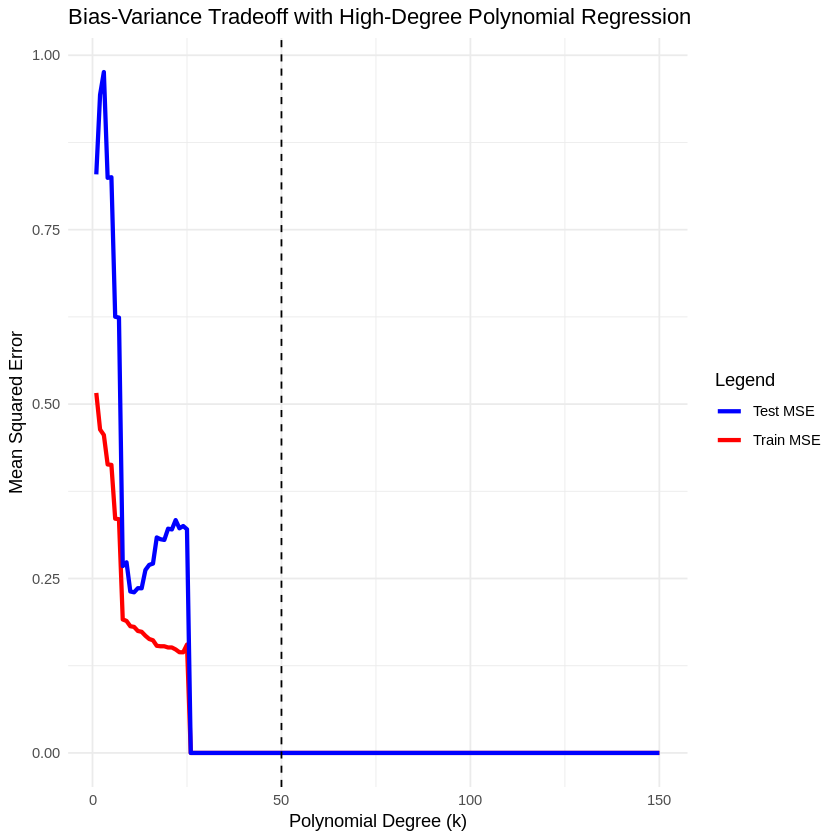

In [30]:
n <- nrow(train_data)
degree <- 1:150


train_rss <- numeric(length(degree))
test_rss <- numeric(length(degree))


for (i in seq_along(degree)) {
  k <- degree[i]


  result <- tryCatch({
    model <- lm(y ~ poly(x, k), data = train_data)

    train_pred <- predict(model, newdata = train_data)
    test_pred <- predict(model, newdata = test_data)

    train_rss[i] <- mean((train_data$y - train_pred)^2)
    test_rss[i] <- mean((test_data$y - test_pred)^2)
  }, error = function(e) {
    train_rss[i] <- NA
    test_rss[i] <- NA
  })
}


df <- data.frame(
  Degree = degree,
  Train_MSE = train_rss,
  Test_MSE = test_rss
)

ggplot(df, aes(x = Degree)) +
  geom_line(aes(y = Train_MSE, color = "Train MSE"), size = 1.2) +
  geom_line(aes(y = Test_MSE, color = "Test MSE"), size = 1.2) +
  geom_vline(xintercept = n, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("blue", "red")) +
  labs(title = "Bias-Variance Tradeoff with High-Degree Polynomial Regression",
       x = "Polynomial Degree (k)",
       y = "Mean Squared Error",
       color = "Legend") +
  theme_minimal()


What do you see as $k$ gets larger than $n$?

> The model starts overfitting the data. As k approaches n, training error approaches zero. When they equal one another, MSE is very small. After that MSE stays low, but is misleading, due to the overfit.


---
## 3. Applying regularization to the model fits (2 points)

Repeat the previous bias-variance tradeoff test, going up to $k=150$, but now use ridge regression with a sparsity parameter of $\lambda=0.00005$. Plot your results the same way as last time.

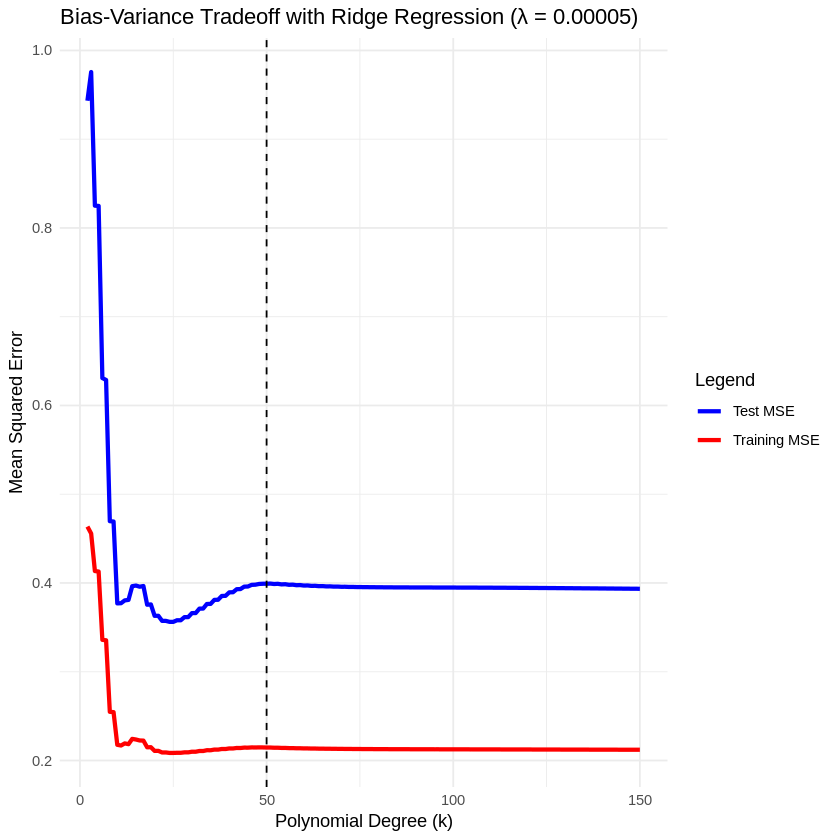

In [32]:
# Now do the variance-bias trade off analysis using ridge regression
lambda=0.00005
degree = seq(2,150)

rm(train_rss, test_rss)
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

for (k in degree) {
    # Create polynomial features with raw = TRUE
    X_train <- model.matrix(y ~ poly(x, k, raw = TRUE), data = train_data)[, -1]
    X_test <- model.matrix(y ~ poly(x, k, raw = TRUE), data = test_data)[, -1]
    y_train <- train_data$y
    y_test <- test_data$y

    # Ridge regression: alpha = 0 for ridge
    model <- glmnet(X_train, y_train, alpha = 0, lambda = lambda, standardize = TRUE)

    # Predict
    train_pred <- predict(model, newx = X_train)
    test_pred <- predict(model, newx = X_test)

    # Store MSE
    train_rss[which(degree == k)] <- mean((y_train - train_pred)^2)
    test_rss[which(degree == k)] <- mean((y_test - test_pred)^2)

}

# Plot your results here

df <- data.frame(
  Degree = degree,
  Train_MSE = train_rss,
  Test_MSE = test_rss
)

# Plot results
ggplot(df, aes(x = Degree)) +
  geom_line(aes(y = Train_MSE, color = "Training MSE"), size = 1.2) +
  geom_line(aes(y = Test_MSE, color = "Test MSE"), size = 1.2) +
  geom_vline(xintercept = n, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("blue", "red")) +
  labs(title = "Bias-Variance Tradeoff with Ridge Regression (λ = 0.00005)",
       x = "Polynomial Degree (k)",
       y = "Mean Squared Error",
       color = "Legend") +
  theme_minimal()





What happens now when $k$ gets larger than $n$?

> Training MSE doesn't drop to zero anymore, because there is the coefficient penalty.

---
## 4. Reflection (2 points)

The simulations above should have shown that, when applying a regularization (i.e., a sparsity constraint), the behavior of the bias-variance tradeoff changes. Explain why this happens.

> Regularization, like ridge regression, adds a penalty on large coefficients, which limits the model's flexibility and reduces overfitting, leading to a controlled increase in bias. This reduces variance, especially when (k > n), improving generalization and stabilizing test error even in complex models.
>

---
## Bonus (1 extra credit point)
Recall that the $p=n$ threshold defines the limit for finding a *unique* solution to $Y=F(X)$ (i.e., there is only one combination of regression coefficients that is *best* at explaining variance in $Y$). With this in mind, what is regularization doing that works around this upper limit?

> Regularization works around the p=n limit by relaxing the requirement for a unique solution, allowing multiple possible solutions but favoring the one with smaller, more stable coefficients. By penalizing model complexity, it effectively chooses a simpler, more generalizable solution even when the number of predictors exceeds the number of observations.
>

**DUE:** 5pm EST, April 10, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*